## Notebook to do longitudinal analysis of eQTL over time
- here using PPMI as discovery cohort and PDBP as replication
- features to be considered, probably should do in separate notebooks
    - expression ~ time + (1| subject)
    - cell fractions ~ time + (1| subject), (caveat cell fractions predicted based on PPMI, so PDBP not full replication)
    - eqtl_betas ~ time
    
based on running linear mixed effects models in python examples:
- [Comparing R lmer to Statsmodels MixedLM](https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb)
- [Linear Mixed Effects Models](https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html)
- [statsmodel mixedlm from formula](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html)

In [1]:
!date

Tue May 11 02:38:07 UTC 2021


#### import libraries and set notebook variables

In [54]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import seaborn as sns

In [141]:
# parameters
disc_cohort = 'ppmi'
rep_cohort = 'pdbp'
tissue = 'wb'
months = [0, 1, 6 , 12, 18, 24, 36]
visit_names = ['BLM0T1', 'SVM0_5T1', 'SVM6T1', 'SVM12T1', 'SVM18T1', 'SVM24T1', 'SVM36T1']
visits = zip(months, visit_names)

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{disc_cohort}'
results_dir = f'{wrk_dir}/results'

# in files
replicated_results_file = f'{results_dir}/{disc_cohort}.{rep_cohort}.replicated.{tissue}.cis.csv'
expr_by_time_file = f'{results_dir}/{disc_cohort}.replicated.expr_time_mm_and_mmcov.csv'

# out files
nominal_time_eqtl_results = f'{results_dir}/{disc_cohort}.{rep_cohort}.replicated.{tissue}.time_cis.csv'

#### analysis functions

In [4]:
# functions to run the linear regression
def reg_model(y, x, term):
    Xb = sm.add_constant(x)
    reg_model = sm.OLS(y, Xb).fit()

# #     formula api style
#     this_formula = f'Q("{this_trait}") ~ GRS + predicted_Lymphocytes + GRS * predicted_Lymphocytes'
#     reg_model = smf.ols(this_formula, data=this_quants).fit()

    # return the coef, stderr, adjusted r2, number of terms, and p-value
    return [reg_model.params[term], reg_model.bse[term], reg_model.rsquared_adj, 
            reg_model.params.shape[0], reg_model.pvalues[term]]


#### load the replicated eQTL

In [7]:
eqtl_df = pd.read_csv(replicated_results_file)
print(eqtl_df.shape)
display(eqtl_df.head())

(188185, 16)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
0,ENSG00000259488.2,rs74011998,-27340,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs74011998,0,inf,65.07998,65.07998,1,ppmi
1,ENSG00000259488.2,rs76749119,-18988,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs76749119,0,inf,65.07998,65.07998,1,ppmi
2,ENSG00000166435.15,rs7105085,-90306,0.233221,497,556,0.0,1.477821,0.022189,ENSG00000166435.15:rs7105085,0,inf,66.60303,66.60303,1,ppmi
3,ENSG00000166435.15,rs4944963,-57064,0.234480,497,559,0.0,1.470023,0.021803,ENSG00000166435.15:rs4944963,0,inf,67.42204,67.42204,1,ppmi
4,ENSG00000166435.15,rs12419929,-48810,0.234060,497,558,0.0,1.473253,0.021874,ENSG00000166435.15:rs12419929,0,inf,67.35073,67.35073,1,ppmi


#### subset the discovery cohort results

In [26]:
disc_eqtl_df = eqtl_df.loc[eqtl_df['cohort'] == disc_cohort]
print(disc_eqtl_df.shape)
display(disc_eqtl_df.head())

(94781, 16)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
0,ENSG00000259488.2,rs74011998,-27340,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs74011998,0,inf,65.07998,65.07998,1,ppmi
1,ENSG00000259488.2,rs76749119,-18988,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs76749119,0,inf,65.07998,65.07998,1,ppmi
2,ENSG00000166435.15,rs7105085,-90306,0.233221,497,556,0.0,1.477821,0.022189,ENSG00000166435.15:rs7105085,0,inf,66.60303,66.60303,1,ppmi
3,ENSG00000166435.15,rs4944963,-57064,0.234480,497,559,0.0,1.470023,0.021803,ENSG00000166435.15:rs4944963,0,inf,67.42204,67.42204,1,ppmi
4,ENSG00000166435.15,rs12419929,-48810,0.234060,497,558,0.0,1.473253,0.021874,ENSG00000166435.15:rs12419929,0,inf,67.35073,67.35073,1,ppmi


#### model the eQTL coefs over time

In [39]:
# get the unique features 
features = set(disc_eqtl_df['cispair'])
print(len(features))

18963


In [41]:
%%time
indep_term = 'month'
dep_term = 'slope'
id_term = 'cispair'
lm_results = [[y] + reg_model(disc_eqtl_df.loc[disc_eqtl_df[id_term] == y, [dep_term]], 
                              disc_eqtl_df.loc[disc_eqtl_df[id_term] == y, [indep_term]], 
                              indep_term) for y in features]

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [44]:
disc_lm_df = pd.DataFrame(data=lm_results, columns=['feature', 'coef', 'stderr', 'r2_adj', 'term_cnt', 'p-value'])
print(disc_lm_df.shape)
display(disc_lm_df.head())

(18963, 6)


,feature,coef,stderr,r2_adj,term_cnt,p-value
0,ENSG00000128944.13:rs12916629,0.000200,0.002361,-0.330163,2,0.937943
1,ENSG00000231187.2:rs75136098,-0.006168,0.001282,0.846999,2,0.017103
2,ENSG00000163389.11:rs75416321,-0.004338,0.003082,0.196966,2,0.253994
3,ENSG00000113273.16:rs62377897,0.005164,0.001386,0.763030,2,0.033678
4,ENSG00000166825.13:rs12442778,-0.001733,0.000665,0.591418,2,0.079978


#### compute B&H FDF

In [75]:
alpha=0.05
method='fdr_bh'
# method='bonferroni'
disc_lm_df['p-value'].fillna(1, inplace=True)
test_adjust = smm.multipletests(np.array(disc_lm_df['p-value']),
                                alpha=alpha, method=method)
disc_lm_df['bh_fdr'] = test_adjust[1]

In [76]:
display(disc_lm_df.head())

,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
0,ENSG00000128944.13:rs12916629,0.000200,0.002361,-0.330163,2,0.937943,0.985359
1,ENSG00000231187.2:rs75136098,-0.006168,0.001282,0.846999,2,0.017103,0.646380
2,ENSG00000163389.11:rs75416321,-0.004338,0.003082,0.196966,2,0.253994,0.743910
3,ENSG00000113273.16:rs62377897,0.005164,0.001386,0.763030,2,0.033678,0.646380
4,ENSG00000166825.13:rs12442778,-0.001733,0.000665,0.591418,2,0.079978,0.661574


In [77]:
disc_lm_df.describe()

,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
count,18963.000000,18962.000000,18962.000000,18963.000000,18963.000000,18963.000000
mean,0.000090,0.002165,0.077941,1.999947,0.435425,0.806786
std,0.003379,0.001526,0.359337,0.007262,0.290548,0.110804
min,-0.029069,0.000077,-0.496553,1.000000,0.000022,0.165652
25%,-0.001691,0.001245,-0.245772,2.000000,0.178575,0.713516
50%,0.000058,0.001817,-0.011547,2.000000,0.400744,0.801384
75%,0.001839,0.002609,0.339902,2.000000,0.677118,0.902607
max,0.080903,0.022571,0.998151,2.000000,1.000000,1.000000


In [79]:
most_sig = disc_lm_df.loc[disc_lm_df['p-value'] == min(disc_lm_df['p-value'])]
# this_lm_df = disc_lm_df.loc[disc_lm_df['feature'] == 'ENSG00000259488.2:rs74011998']
display(most_sig)

,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
980,ENSG00000108590.10:rs72835770,-0.009027,0.000194,0.998151,2,0.000022,0.165652


<AxesSubplot:xlabel='month', ylabel='slope'>

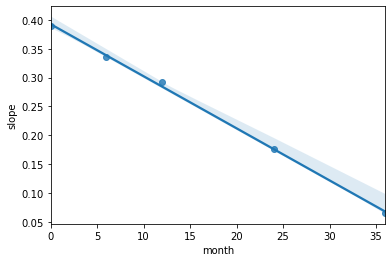

In [67]:
this_pair_df = disc_eqtl_df.loc[disc_eqtl_df['cispair'] == most_sig['feature'].values[0]]
sns.regplot(x='month', y='slope', data=this_pair_df)

In [82]:
nom_sig = disc_lm_df.loc[disc_lm_df['p-value'] < 0.05]
print(nom_sig.shape)
display(nom_sig.head())

(1430, 7)


,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
1,ENSG00000231187.2:rs75136098,-0.006168,0.001282,0.846999,2,0.017103,0.646380
3,ENSG00000113273.16:rs62377897,0.005164,0.001386,0.763030,2,0.033678,0.646380
5,ENSG00000187189.10:rs2232466,-0.004691,0.001234,0.770728,2,0.031986,0.646380
9,ENSG00000268758.7:rs2131747,0.002146,0.000638,0.720599,2,0.043605,0.647882
13,ENSG00000197961.11:rs73492628,-0.005562,0.001376,0.793104,2,0.027262,0.646380


#### check replication cohort eQTL from replication of eQTL time values

the significant results result set was empty in the discovery cohort even when using BH FDR, but some look pretty linear of course just using 5 data points, so go forward with nominal for replication

#### subset the replication cohort results

In [86]:
rep_eqtl_df = eqtl_df.loc[eqtl_df['cohort'] == rep_cohort]
print(rep_eqtl_df.shape)
display(rep_eqtl_df.head())

(93404, 16)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
25,ENSG00000226752.9,rs13299616,7697,0.417652,777,989,0.0,1.279677,0.016116,ENSG00000226752.9:rs13299616,0,inf,79.406181,79.406181,1,pdbp
26,ENSG00000226752.9,rs72298225,18605,0.417652,777,989,0.0,1.280323,0.016052,ENSG00000226752.9:rs72298225,0,inf,79.761345,79.761345,1,pdbp
27,ENSG00000226752.9,rs4837796,23182,0.421875,781,999,0.0,1.267931,0.016370,ENSG00000226752.9:rs4837796,0,inf,77.454262,77.454262,1,pdbp
28,ENSG00000256660.5,rs7314437,-52027,0.265625,545,629,0.0,1.318251,0.023304,ENSG00000256660.5:rs7314437,0,inf,56.568775,56.568775,1,pdbp
29,ENSG00000256660.5,rs7304783,-47835,0.266470,547,631,0.0,1.322751,0.023106,ENSG00000256660.5:rs7304783,0,inf,57.247871,57.247871,1,pdbp


In [87]:
# get the unique features 
features = set(nom_sig['feature'])
print(len(features))

1430


In [88]:
%%time
indep_term = 'month'
dep_term = 'slope'
id_term = 'cispair'
lm_results = [[y] + reg_model(rep_eqtl_df.loc[rep_eqtl_df[id_term] == y, [dep_term]], 
                              rep_eqtl_df.loc[rep_eqtl_df[id_term] == y, [indep_term]], 
                              indep_term) for y in features]

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1729: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.7/

CPU times: user 20 s, sys: 11.6 ms, total: 20 s
Wall time: 20 s


/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1729: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))


In [89]:
rep_lm_df = pd.DataFrame(data=lm_results, columns=['feature', 'coef', 'stderr', 'r2_adj', 'term_cnt', 'p-value'])
print(rep_lm_df.shape)
display(rep_lm_df.head())

(1430, 6)


,feature,coef,stderr,r2_adj,term_cnt,p-value
0,ENSG00000231187.2:rs75136098,0.003362,0.006176,-0.213475,2,0.624053
1,ENSG00000113273.16:rs62377897,-0.004579,0.002076,0.491529,2,0.114521
2,ENSG00000256660.5:rs4764194,0.001694,0.001941,-0.063357,2,0.447037
3,ENSG00000187189.10:rs2232466,0.006992,0.021300,-0.287108,2,0.764305
4,ENSG00000125430.8:rs146593454,-0.002344,0.006909,-0.284072,2,0.756781


#### compute B&H FDF

In [90]:
alpha=0.05
method='fdr_bh'
# method='bonferroni'
rep_lm_df['p-value'].fillna(1, inplace=True)
test_adjust = smm.multipletests(np.array(rep_lm_df['p-value']),
                                alpha=alpha, method=method)
rep_lm_df['bh_fdr'] = test_adjust[1]

In [91]:
display(rep_lm_df.head())

,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
0,ENSG00000231187.2:rs75136098,0.003362,0.006176,-0.213475,2,0.624053,0.992558
1,ENSG00000113273.16:rs62377897,-0.004579,0.002076,0.491529,2,0.114521,0.869650
2,ENSG00000256660.5:rs4764194,0.001694,0.001941,-0.063357,2,0.447037,0.958592
3,ENSG00000187189.10:rs2232466,0.006992,0.021300,-0.287108,2,0.764305,0.992558
4,ENSG00000125430.8:rs146593454,-0.002344,0.006909,-0.284072,2,0.756781,0.992558


In [92]:
rep_lm_df.describe()

,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
count,1430.000000,1423.000000,1406.000000,1430.000000,1430.000000,1430.000000
mean,0.000257,inf,0.016854,1.993706,0.494308,0.931885
std,0.005205,NaN,0.359706,0.079111,0.298056,0.092005
min,-0.028917,0.000302,-0.995064,1.000000,0.002692,0.625114
25%,-0.002150,0.001863,-0.281720,2.000000,0.240691,0.906285
50%,0.000226,0.002773,-0.100088,2.000000,0.496544,0.988644
75%,0.002403,0.004173,0.225360,2.000000,0.761774,0.992558
max,0.050675,inf,0.954632,2.000000,1.000000,1.000000


#### grab the nominally replicated results, merge cohort stats and save

In [112]:
nom_rep_sig = rep_lm_df.loc[rep_lm_df['p-value'] < 0.05]
nom_rep_sig['cohort'] = rep_cohort
print(nom_rep_sig.shape)
# display(nom_rep_sig.head())
nom_disc_sig = disc_lm_df.loc[disc_lm_df['feature'].isin(nom_rep_sig['feature'])]
nom_disc_sig['cohort'] = disc_cohort
print(nom_disc_sig.shape)
# display(nom_disc_sig.head())
nom_replicated_df = pd.concat([nom_disc_sig, nom_rep_sig]).sort_values(by=['feature', 'cohort'])
print(nom_replicated_df.shape)
display(nom_replicated_df.head())
nom_replicated_df.to_csv(nominal_time_eqtl_results, index=False)

(96, 8)
(96, 8)
(192, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr,cohort
381,ENSG00000025708.13:rs131822,-0.004825,0.001444,0.717722,2,0.044314,0.733739,pdbp
15540,ENSG00000025708.13:rs131822,-0.002573,0.000682,0.767810,2,0.032623,0.646380,ppmi
710,ENSG00000025708.13:rs140522,-0.005855,0.001784,0.709618,2,0.046338,0.733739,pdbp
7112,ENSG00000025708.13:rs140522,0.001080,0.000319,0.723070,2,0.042999,0.647882,ppmi
45,ENSG00000029725.16:rs11657691,0.004894,0.001072,0.832183,2,0.019719,0.655779,pdbp


In [125]:
nom_replicated_df.describe()

,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr,log10_pvalue,z_score
count,192.000000,192.000000,192.000000,192.0,192.000000,192.000000,192.000000,192.000000
mean,0.000224,0.001193,0.809364,2.0,0.026027,0.656050,1.688905,0.360738
std,0.005985,0.000848,0.077791,0.0,0.014793,0.034756,0.345886,4.945934
min,-0.022690,0.000082,0.695689,2.0,0.001081,0.594084,1.301894,-12.589293
25%,-0.004113,0.000663,0.741396,2.0,0.013873,0.625114,1.408163,-3.846351
50%,0.002298,0.000985,0.802040,2.0,0.025744,0.646380,1.589339,3.208633
75%,0.004641,0.001446,0.866500,2.0,0.039069,0.662803,1.857820,4.379634
max,0.016537,0.006254,0.975231,2.0,0.049901,0.733739,2.966311,9.228606


#### do some plotting

In [113]:
nom_replicated_df['log10_pvalue'] = np.log10(nom_replicated_df['p-value'])*-1
nom_replicated_df['z_score'] = nom_replicated_df['coef']/nom_replicated_df['stderr']
display(nom_replicated_df.head())

,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr,cohort,log10_pvalue,z_score
381,ENSG00000025708.13:rs131822,-0.004825,0.001444,0.717722,2,0.044314,0.733739,pdbp,1.353455,-3.342216
15540,ENSG00000025708.13:rs131822,-0.002573,0.000682,0.767810,2,0.032623,0.646380,ppmi,1.486473,-3.771905
710,ENSG00000025708.13:rs140522,-0.005855,0.001784,0.709618,2,0.046338,0.733739,pdbp,1.334065,-3.282524
7112,ENSG00000025708.13:rs140522,0.001080,0.000319,0.723070,2,0.042999,0.647882,ppmi,1.366543,3.382913
45,ENSG00000029725.16:rs11657691,0.004894,0.001072,0.832183,2,0.019719,0.655779,pdbp,1.705110,4.564592


<AxesSubplot:xlabel='coef', ylabel='log10_pvalue'>

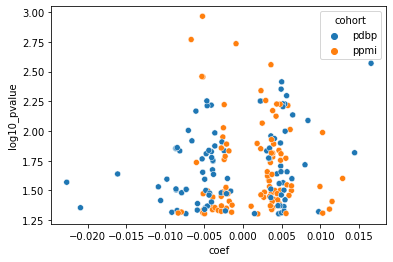

In [114]:
sns.scatterplot(x='coef', y='log10_pvalue', hue='cohort', data=nom_replicated_df)

<AxesSubplot:xlabel='z_score', ylabel='log10_pvalue'>

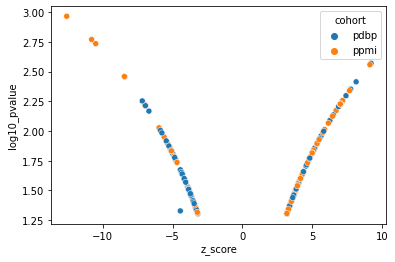

In [115]:
sns.scatterplot(x='z_score', y='log10_pvalue', hue='cohort', data=nom_replicated_df)

In [ ]:
replicated_time_eqtl

#### annotate direction of effect for plotting

In [117]:
eqtl_df['Direction'] = np.where(eqtl_df['slope'] > 0, 'Increase', 'Descrease')
display(eqtl_df.sample(5))

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort,Direction
125333,ENSG00000242779.6,rs189069,-44671,0.062684,82,85,5.025688e-06,-0.512376,0.111360,ENSG00000242779.6:rs189069,24,5.298805,-4.601092,4.601092,1,ppmi,Descrease
163370,ENSG00000205045.8,rs11650473,-248,0.244213,183,211,3.190568e-03,0.192204,0.064810,ENSG00000205045.8:rs11650473,18,2.496132,2.965661,2.965661,1,pdbp,Increase
99706,ENSG00000235290.1,rs9261418,152287,0.159722,127,138,2.912652e-08,0.462229,0.081782,ENSG00000235290.1:rs9261418,18,7.535711,5.651940,5.651940,1,pdbp,Increase
58118,ENSG00000273802.2,rs79662647,925,0.083222,119,125,9.500888e-15,-0.711852,0.090024,ENSG00000273802.2:rs79662647,6,14.022236,-7.907323,7.907323,1,ppmi,Descrease
36736,ENSG00000116922.14,rs57669144,11872,0.175245,126,143,2.476178e-22,0.806482,0.078081,ENSG00000116922.14:rs57669144,24,21.606218,10.328811,10.328811,1,pdbp,Increase


In [118]:
time_eqtl = eqtl_df.loc[eqtl_df['cispair'].isin(nom_replicated_df['feature'])]
print(time_eqtl.shape)

(959, 17)


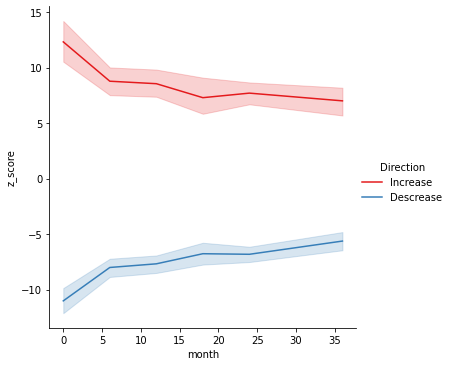

In [121]:
sns.relplot(x='month', y='z_score', kind='line', hue='Direction',
            data=time_eqtl, palette='Set1')

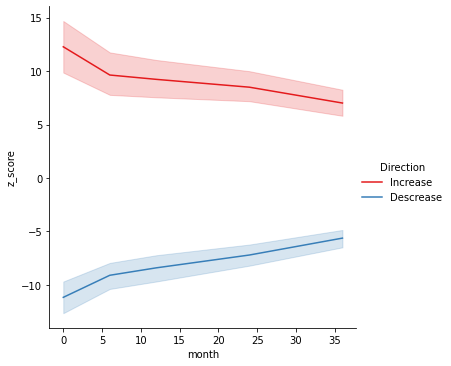

In [120]:
sns.relplot(x='month', y='z_score', kind='line', hue='Direction',
            data=time_eqtl.loc[time_eqtl['cohort'] == disc_cohort], palette='Set1')

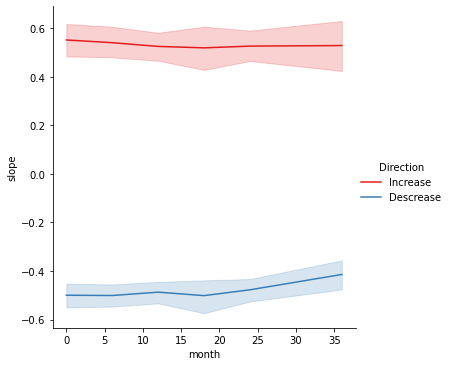

In [123]:
sns.relplot(x='month', y='slope', kind='line', hue='Direction',
            data=time_eqtl, palette='Set1')

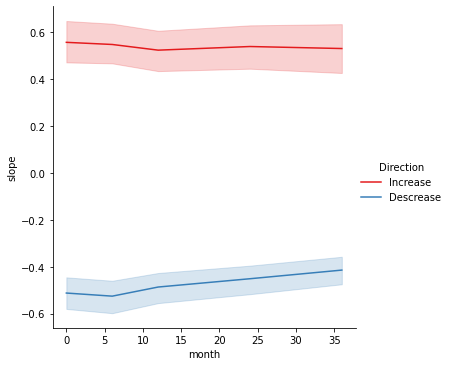

In [124]:
sns.relplot(x='month', y='slope', kind='line', hue='Direction',
            data=time_eqtl.loc[time_eqtl['cohort'] == disc_cohort], palette='Set1')

In [126]:
time_eqtl.head()

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort,Direction
500,ENSG00000124587.13,rs3805952,-9832,0.454814,823,1077,1.080429e-189,1.028885,0.028826,ENSG00000124587.13:rs3805952,0,188.966404,35.692871,35.692871,1,pdbp,Increase
517,ENSG00000124587.13,rs9462858,-468,0.455659,825,1079,1.067691e-188,1.028541,0.028925,ENSG00000124587.13:rs9462858,0,187.971554,35.559341,35.559341,1,pdbp,Increase
524,ENSG00000124587.13,rs143162448,-20481,0.453125,821,1073,5.346495e-188,1.026255,0.028937,ENSG00000124587.13:rs143162448,0,187.271931,35.465446,35.465446,1,pdbp,Increase
765,ENSG00000124587.13,rs3805952,-9832,0.422819,811,1008,1.921237e-168,1.000773,0.030509,ENSG00000124587.13:rs3805952,0,167.716419,32.802074,32.802074,1,ppmi,Increase
780,ENSG00000124587.13,rs9462858,-468,0.422819,812,1008,1.592203e-167,1.000537,0.030617,ENSG00000124587.13:rs9462858,0,166.798001,32.679173,32.679173,1,ppmi,Increase


In [127]:
nom_replicated_df.head()

,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr,cohort,log10_pvalue,z_score
381,ENSG00000025708.13:rs131822,-0.004825,0.001444,0.717722,2,0.044314,0.733739,pdbp,1.353455,-3.342216
15540,ENSG00000025708.13:rs131822,-0.002573,0.000682,0.767810,2,0.032623,0.646380,ppmi,1.486473,-3.771905
710,ENSG00000025708.13:rs140522,-0.005855,0.001784,0.709618,2,0.046338,0.733739,pdbp,1.334065,-3.282524
7112,ENSG00000025708.13:rs140522,0.001080,0.000319,0.723070,2,0.042999,0.647882,ppmi,1.366543,3.382913
45,ENSG00000029725.16:rs11657691,0.004894,0.001072,0.832183,2,0.019719,0.655779,pdbp,1.705110,4.564592


In [134]:
increasing_df = nom_replicated_df.loc[nom_replicated_df['coef'] > 0]
decreasing_df = nom_replicated_df.loc[nom_replicated_df['coef'] < 0]
best_increasing_df = increasing_df.loc[increasing_df['r2_adj'] == max(increasing_df['r2_adj'])]
display(best_increasing_df)
best_decreasing_df = decreasing_df.loc[decreasing_df['r2_adj'] == min(decreasing_df['r2_adj'])]
display(best_decreasing_df)

,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr,cohort,log10_pvalue,z_score
789,ENSG00000126870.15:rs7800531,0.016537,0.001792,0.954632,2,0.002692,0.625114,pdbp,2.569997,9.228606


,feature,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr,cohort,log10_pvalue,z_score
18560,ENSG00000124587.13:rs9462858,-0.004925,0.001544,0.696235,2,0.049759,0.647882,ppmi,1.303127,-3.188739


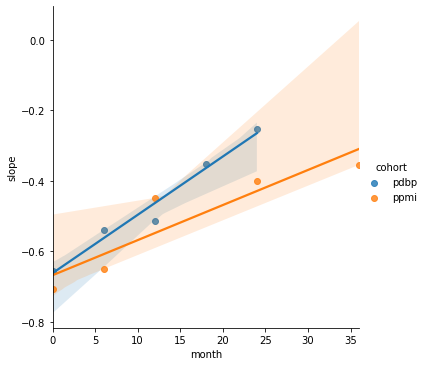

In [135]:
this_pair_df = eqtl_df.loc[eqtl_df['cispair'] == best_increasing_df['feature'].values[0]]
sns.lmplot(x='month', y='slope', data=this_pair_df, hue='cohort')

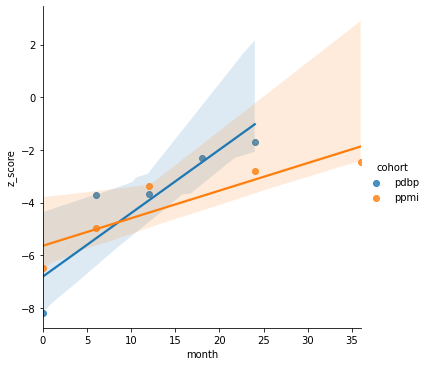

In [138]:
this_pair_df = eqtl_df.loc[eqtl_df['cispair'] == best_increasing_df['feature'].values[0]]
sns.lmplot(x='month', y='z_score', data=this_pair_df, hue='cohort')

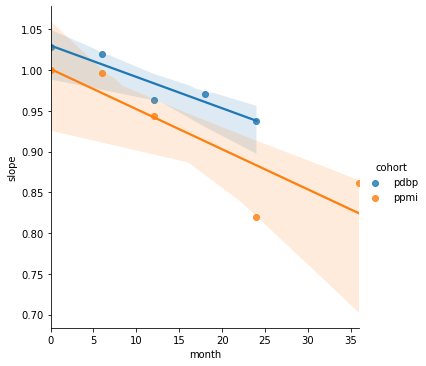

In [139]:
this_pair_df = eqtl_df.loc[eqtl_df['cispair'] == best_decreasing_df['feature'].values[0]]
sns.lmplot(x='month', y='slope', data=this_pair_df, hue='cohort')

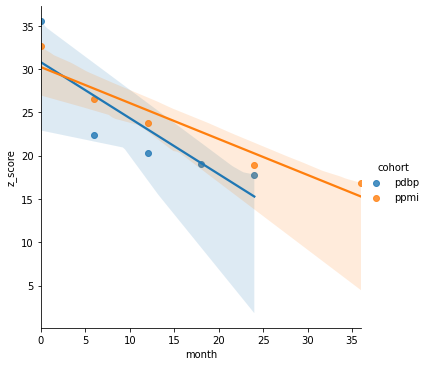

In [140]:
this_pair_df = eqtl_df.loc[eqtl_df['cispair'] == best_decreasing_df['feature'].values[0]]
sns.lmplot(x='month', y='z_score', data=this_pair_df, hue='cohort')

#### check the time eQTL results against the expression by time results

In [142]:
time_expr = pd.read_csv(expr_by_time_file)
print(time_expr.shape)
display(time_expr.head())

(9852, 7)


,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02,PP
1,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13,1.682146e-11,PP
2,ENSG00000185164.14,0.002418,0.000926,3,9.054107e-03,2.074218e-02,PP
3,ENSG00000207166.1,0.007776,0.001026,3,3.499672e-14,1.188200e-12,PP
4,ENSG00000246731.2,-0.003225,0.001123,3,4.064190e-03,1.034898e-02,PP


In [143]:
time_expr['cohort'].value_counts()

PP    4926
PD    4926
Name: cohort, dtype: int64

In [144]:
change_time_features = set(time_expr['feature']) & set(time_eqtl['phenotype_id'])
print(len(set(change_time_features)))

27


In [156]:
# for the change_time_features merge time_expr and time_eqtl
time_results = time_expr.merge(time_eqtl.loc[time_eqtl['month'] == 0], how='inner', 
                               left_on='feature', right_on='phenotype_id')
print(time_results.shape)
display(time_results.head())

(184, 24)


,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort_x,phenotype_id,variant_id,tss_distance,...,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort_y,Direction
0,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs35945739,31594,...,0.874122,0.057354,ENSG00000229739.2:rs35945739,0,47.304503,15.240917,15.240917,1,ppmi,Increase
1,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs12747113,-10999,...,0.866893,0.057306,ENSG00000229739.2:rs12747113,0,46.676045,15.127560,15.127560,1,ppmi,Increase
2,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs12747113,-10999,...,0.828808,0.055560,ENSG00000229739.2:rs12747113,0,45.494716,14.917433,14.917433,1,pdbp,Increase
3,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs35945739,31594,...,0.828882,0.056239,ENSG00000229739.2:rs35945739,0,44.519379,14.738487,14.738487,1,pdbp,Increase
4,ENSG00000229739.2,0.008455,0.001685,3,5.257302e-07,0.000003,PD,ENSG00000229739.2,rs35945739,31594,...,0.874122,0.057354,ENSG00000229739.2:rs35945739,0,47.304503,15.240917,15.240917,1,ppmi,Increase


In [157]:
len(time_results['feature'].unique())

27

In [158]:
time_results.columns

Index(['feature', 'coef', 'stderr', 'term_cnt', 'p-value', 'bh_fdr',
       'cohort_x', 'phenotype_id', 'variant_id', 'tss_distance', 'af',
       'ma_samples', 'ma_count', 'pval_nominal', 'slope', 'slope_se',
       'cispair', 'month', 'log10_pvalue', 'z_score', 'z_score_abs', 'is_sig',
       'cohort_y', 'Direction'],
      dtype='object')

<AxesSubplot:xlabel='coef', ylabel='slope'>

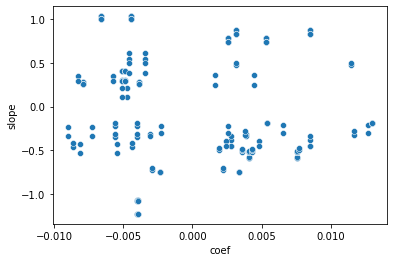

In [161]:
sns.scatterplot(x='coef', y='slope', data=time_results)

In [162]:
time_results[['coef', 'slope']].corr()

,coef,slope
coef,1.000000,-0.154795
slope,-0.154795,1.000000


In [164]:
nom_replicated_df

time_results2 = time_results.merge(nom_replicated_df, how='inner', 
                                   left_on='cispair', right_on='feature')
print(time_results2.shape)
display(time_results2.head())

(368, 34)


,feature_x,coef_x,stderr_x,term_cnt_x,p-value_x,bh_fdr_x,cohort_x,phenotype_id,variant_id,tss_distance,...,feature_y,coef_y,stderr_y,r2_adj,term_cnt_y,p-value_y,bh_fdr_y,cohort,log10_pvalue_y,z_score_y
0,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs35945739,31594,...,ENSG00000229739.2:rs35945739,0.003409,0.000708,0.847385,2,0.017037,0.625114,pdbp,1.768607,4.817654
1,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs35945739,31594,...,ENSG00000229739.2:rs35945739,-0.002235,0.000597,0.764656,2,0.033318,0.646380,ppmi,1.477326,-3.741175
2,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs35945739,31594,...,ENSG00000229739.2:rs35945739,0.003409,0.000708,0.847385,2,0.017037,0.625114,pdbp,1.768607,4.817654
3,ENSG00000229739.2,0.003111,0.001025,3,2.397754e-03,0.006566,PP,ENSG00000229739.2,rs35945739,31594,...,ENSG00000229739.2:rs35945739,-0.002235,0.000597,0.764656,2,0.033318,0.646380,ppmi,1.477326,-3.741175
4,ENSG00000229739.2,0.008455,0.001685,3,5.257302e-07,0.000003,PD,ENSG00000229739.2,rs35945739,31594,...,ENSG00000229739.2:rs35945739,0.003409,0.000708,0.847385,2,0.017037,0.625114,pdbp,1.768607,4.817654


In [165]:
time_results2.columns

Index(['feature_x', 'coef_x', 'stderr_x', 'term_cnt_x', 'p-value_x',
       'bh_fdr_x', 'cohort_x', 'phenotype_id', 'variant_id', 'tss_distance',
       'af', 'ma_samples', 'ma_count', 'pval_nominal', 'slope', 'slope_se',
       'cispair', 'month', 'log10_pvalue_x', 'z_score_x', 'z_score_abs',
       'is_sig', 'cohort_y', 'Direction', 'feature_y', 'coef_y', 'stderr_y',
       'r2_adj', 'term_cnt_y', 'p-value_y', 'bh_fdr_y', 'cohort',
       'log10_pvalue_y', 'z_score_y'],
      dtype='object')

<AxesSubplot:xlabel='coef_x', ylabel='coef_y'>

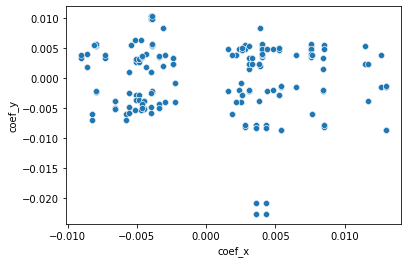

In [166]:
sns.scatterplot(x='coef_x', y='coef_y', data=time_results2)

In [167]:
time_results2[['coef_x', 'coef_y']].corr()

,coef_x,coef_y
coef_x,1.000000,-0.068935
coef_y,-0.068935,1.000000
